# Named Entity Recognition Model using Pytorch and Hugging Face Transformers

Will create a NER model that will extract company names from emails using custom neural network models, transformers, and hybrid models using Pytorch and HuggingFace.

</br></br>

- Import Libararies and Dependencies
  - Fetch and load kaggle ner dataset
  - Load CoNLL03 dataset
  - Load Job Data
- Clean and Combine Datasets
  - Transform datasets to standard form
  - Fill null values, drop irrelevant columns, drop duplicates
  - Convert NER tags to numerical values
  - Combine all datasets to one dataframe
- Exploratory Data Analysis (EDA)
  - Visualize NER tags by count
  - Plot distribution of sentence lengths in dataset
  - Visualize most common words per NER tag
- Preprocess Data
  - Tokenize data with BertTokenizer
  - Store data into Pytorch DataLoader object
- Create and Define Model Architectures
  - Implement a baseline Bi-LSTM neural network
  - Implement a Gated Convolution Neural Network
  - Import a BERT based model from HuggingFace
- Train Models
  - Create training function for standard neural network models
  - Create training function for BERT based model
- Model Evaluation
  - Compare metrics between 3 models
  - Plot confusion matrices and metrics
- Model Inferencing
  - Create inferencing function for highest performing model

</br></br>

---
</br>

### Import Libaries and Dependencies

In [ ]:
!pip install datasets
!pip install kaggle
!pip install scikit-plot
#https://arxiv.org/pdf/1812.09449.pdf

In [109]:
import nltk
import string
import json
import builtins
import torch
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from datasets import load_dataset
from transformers import BertForTokenClassification
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import random_split
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import scikitplot as skplt

In [112]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

---

</br>

### Import Datasets

</br>

For this project, will use the following datasets:
1. CoNLL2003 dataset
2. Entity-annotated-corpus dataset from Kaggle
3. Custom dataset based on personal job emails

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 76% 20.0M/26.4M [00:00<00:00, 56.4MB/s]
100% 26.4M/26.4M [00:00<00:00, 57.0MB/s]


In [7]:
kaggle_json = {"username":"",
               "key":""}

with open('kaggle.json', 'w') as fp:
    json.dump(kaggle_json, fp)

In [8]:
path = '/content/entity-annotated-corpus.zip'
with ZipFile(path, 'r') as zip:
  zip.extractall()

In [146]:
kaggle_ner = pd.read_csv('/content/ner_dataset.csv', encoding='mac_roman')
conll03 = load_dataset("conll2003")
job_data = pd.read_csv('Job-Data.csv')

---

</br>

### Clean and Combine Datasets

</br>

Will clean and preprocess the datasets through various techinques such as filling missing values, converting columns to interpretable formats, dropping irrelevant features, etc.

In [147]:
# Preprocess 'kaggle_ner' dataset


def reformat_data(sentence): # reformat columns
  sent, tags = [], []

  sentence['Word'].apply(lambda x: sent.append(str(x) + ' '))
  sentence['Tag'].apply(lambda x: tags.append(x))

  return ''.join(sent), tags

pd.options.mode.chained_assignment = None

# Fill NA values
kaggle_ner = kaggle_ner.fillna(method="ffill")

# Reformat data
sentence_tag_pairs = kaggle_ner.groupby('Sentence #').apply(reformat_data)

# Drop duplicates and update columns
kaggle_ner = kaggle_ner.drop_duplicates(subset=['Sentence #'])
kaggle_ner['Sentence'] = sentence_tag_pairs.apply(lambda x: x[0]).values
kaggle_ner['Tag'] = sentence_tag_pairs.apply(lambda x: x[1]).values

# Drop unecessary columns
unwanted_cols = ['Sentence #', 'Word', 'POS']
kaggle_ner.drop(labels=unwanted_cols, axis=1, inplace=True)
kaggle_ner.reset_index(drop=True, inplace=True)

kaggle_ner.head()

,Tag,Sentence
0,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",Thousands of demonstrators have marched throug...
1,"[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...",Iranian officials say they expect to get acces...
2,"[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...",Helicopter gunships Saturday pounded militant ...
3,"[O, O, O, O, O, O, O, O, O, O, O]",They left after a tense hour-long standoff wit...
4,"[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...",U.N. relief coordinator Jan Egeland said Sunda...


In [148]:
# Preprocess 'job_data' dataset


def StrToArr(tag):
  return [token.strip(" '") for token in tag.strip('[]').split(',')]

# Drop nan values
job_data = job_data[job_data['NER_Tags'].notna()]

# Drop unecessary features
unwanted_cols = ['Company', 'Status', 'Job_Related', 'Unnamed: 5']
job_data = job_data.drop(labels=unwanted_cols, axis=1)

# Rename columns
job_data.reset_index(drop=True, inplace=True)
job_data.rename(columns={'Email': 'Sentence', 'NER_Tags': 'Tag'},
                                                    inplace=True)

job_data['Tag'] = job_data['Tag'].apply(StrToArr)

job_data.head()

,Sentence,Tag
0,Thank you for applying to the Junior Software ...,"[O, O, O, O, O, O, B-MISC, I-MISC, I-MISC, O, ..."
1,Thank you for your interest in the Software En...,"[O, O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-..."
2,Thank you for applying to the Java Developer p...,"[O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-ORG..."
3,Thank you for your interest in the Web Develop...,"[O, O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-..."
4,Thanks for your interest in Fritz AI. Unfortun...,"[O, O, O, O, O, B-ORG, I-ORG, O, O, O, O, O, O..."


In [149]:
# Preprocess 'conll03' dataset


def conll03_preprocessor(data):
  def to_str(token):
    arr = [i + ' ' for i in token]
    return ''.join(arr)

  # Drop unwanted columns
  unwanted_cols = ['pos_tags', 'chunk_tags', 'id']
  data = data.drop(labels=unwanted_cols, axis=1)

  # Convert tokens to strings
  data['tokens'] = data['tokens'].apply(to_str)
  data.rename(columns={'tokens':'Sentence', 'ner_tags':'Tag'},
                                                  inplace=True)
  return data

# Perform preprocessing steps for each dataset
conll03_train = conll03_preprocessor(pd.DataFrame(conll03['train']))
conll03_valid = conll03_preprocessor(pd.DataFrame(conll03['validation']))
conll03_test = conll03_preprocessor(pd.DataFrame(conll03['test']))

conll03_train.head()

,Sentence,Tag
0,EU rejects German call to boycott British lamb .,"[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,Peter Blackburn,"[1, 2]"
2,BRUSSELS 1996-08-22,"[5, 0]"
3,The European Commission said on Thursday it di...,"[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,Germany 's representative to the European Unio...,"[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


</br>


Now all the datasets have been preprocessed, however the NER tags for each dataset are numbered differently, so make it consistent.

In [150]:
def tags_to_idx(tags):
  # Map each tag to a corresponding value
  tag_idx_dict = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                  'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7,
                  'I-MISC': 8, 'I-PERS': 2, 'B-GEO': 5, 'I-GEO': 6,
                  'B-GPE': 5, 'I-GPE': 6, 'B-TIM': 7, 'I-TIM': 8,
                  'B-ART': 7, 'I-ART': 8, 'B-NAT': 0, 'I-NAT': 0,
                  'B-EVE': 0,'I-EVE': 0}

  return [tag_idx_dict[i.upper()] for i in tags]

job_data['Tag'] = job_data['Tag'].apply(tags_to_idx)
kaggle_ner['Tag'] = kaggle_ner['Tag'].apply(tags_to_idx)

kaggle_ner.head()

,Tag,Sentence
0,"[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, ...",Thousands of demonstrators have marched throug...
1,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Iranian officials say they expect to get acces...
2,"[0, 0, 7, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, ...",Helicopter gunships Saturday pounded militant ...
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",They left after a tense hour-long standoff wit...
4,"[5, 0, 0, 1, 2, 0, 7, 0, 5, 0, 5, 0, 5, 0, 0, ...",U.N. relief coordinator Jan Egeland said Sunda...


</br>

Finally, we will combine all the datasets into one dataframe and this will be the final dataset for the model.

In [151]:
ner_corpus = pd.concat([job_data, kaggle_ner, conll03_train,
                                conll03_valid, conll03_test],
                                          ignore_index=True)

In [152]:
ner_corpus.head()

,Sentence,Tag
0,Thank you for applying to the Junior Software ...,"[0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 0, 3, 4, 0, 3, ..."
1,Thank you for your interest in the Software En...,"[0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 4, 4, 0, ..."
2,Thank you for applying to the Java Developer p...,"[0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 4, 4, 0, 3, ..."
3,Thank you for your interest in the Web Develop...,"[0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 0, 5, 6, ..."
4,Thanks for your interest in Fritz AI. Unfortun...,"[0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."


---

</br>

### Exploratory Data Analysis (EDA)

</br>

The EDA pipeline for this project will follow:
- Count frequency of tags
- Plot histogram of sentence lengths in data
- Find top most frequent words per NER tag

In [16]:
tag_ids_to_tag = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG',
                  5:'B-LOC', 6:'I-LOC', 7:'B-MISC', 8:'I-MISC'}

Count of 'O' Tag:  1139740


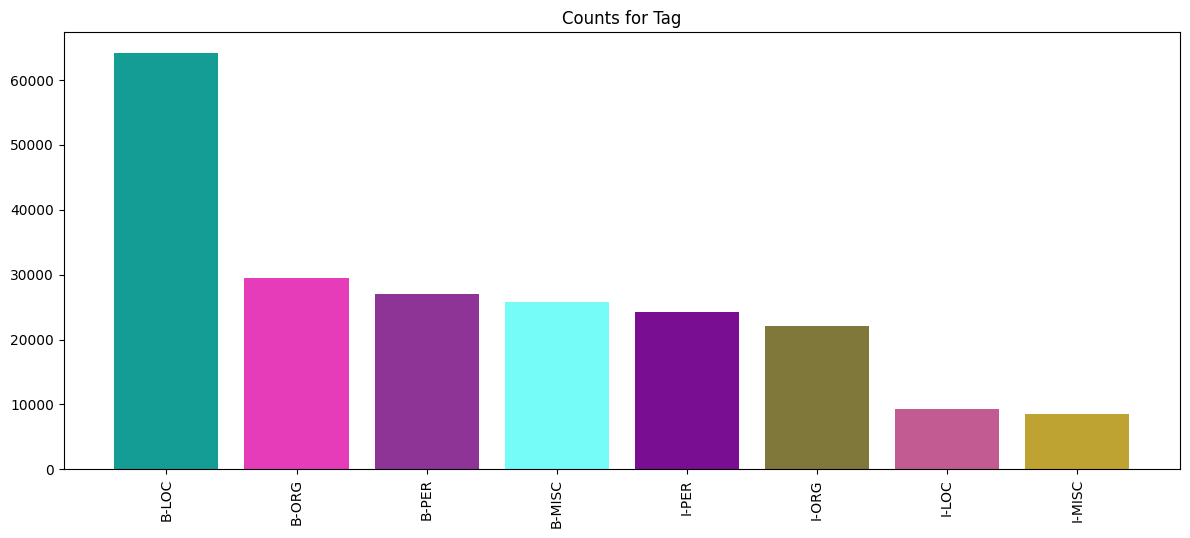

In [156]:
plt.figure(figsize=(12, 10))

def plotCounts(data, col, i):
  # Find counts for each NER tag
  counter = Counter()
  data[col].apply(lambda x : counter.update(x))

  # Sort array of NER tags by frequency of tag
  arr = sorted(builtins.zip(list(counter.values()), list(counter.keys())),
                                                    reverse=True)
  y, x = builtins.zip(*arr)

  # Get x, y arrays to plot
  x = list(x)
  y = list(y)
  for j in range(len(x)):
    x[j] = tag_ids_to_tag[x[j]]

  x.pop(0)
  o_count = y.pop(0)

  # Plot tag counts
  plt.subplot(2, 1, i)
  plt.bar(x=x, height=y, color=np.random.rand(len(arr), 3))
  plt.xticks(rotation=90, ha='center')
  plt.title("Counts for " + col)
  plt.tight_layout()

  # Print O tag count since its most frequent, would mess up bar chart
  print("Count of 'O' Tag: ", o_count)

plotCounts(ner_corpus, 'Tag', 1)

In [18]:
"Number of duplicates: " + str(sum(ner_corpus['Sentence'].duplicated()))

'Number of duplicates: 2403'

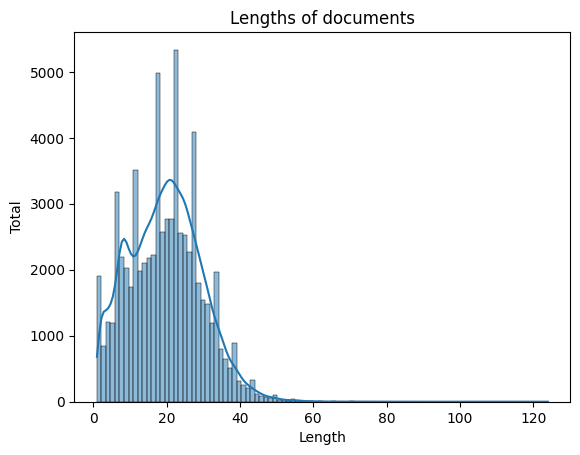

In [158]:
# Find sentence lengths for each sentence
arr = ner_corpus['Sentence'].apply(lambda x: len(x.split())).values
sns.histplot(arr, bins=100, kde=True)
plt.title("Lengths of documents")
plt.xlabel("Length")
plt.ylabel("Total")
plt.show()

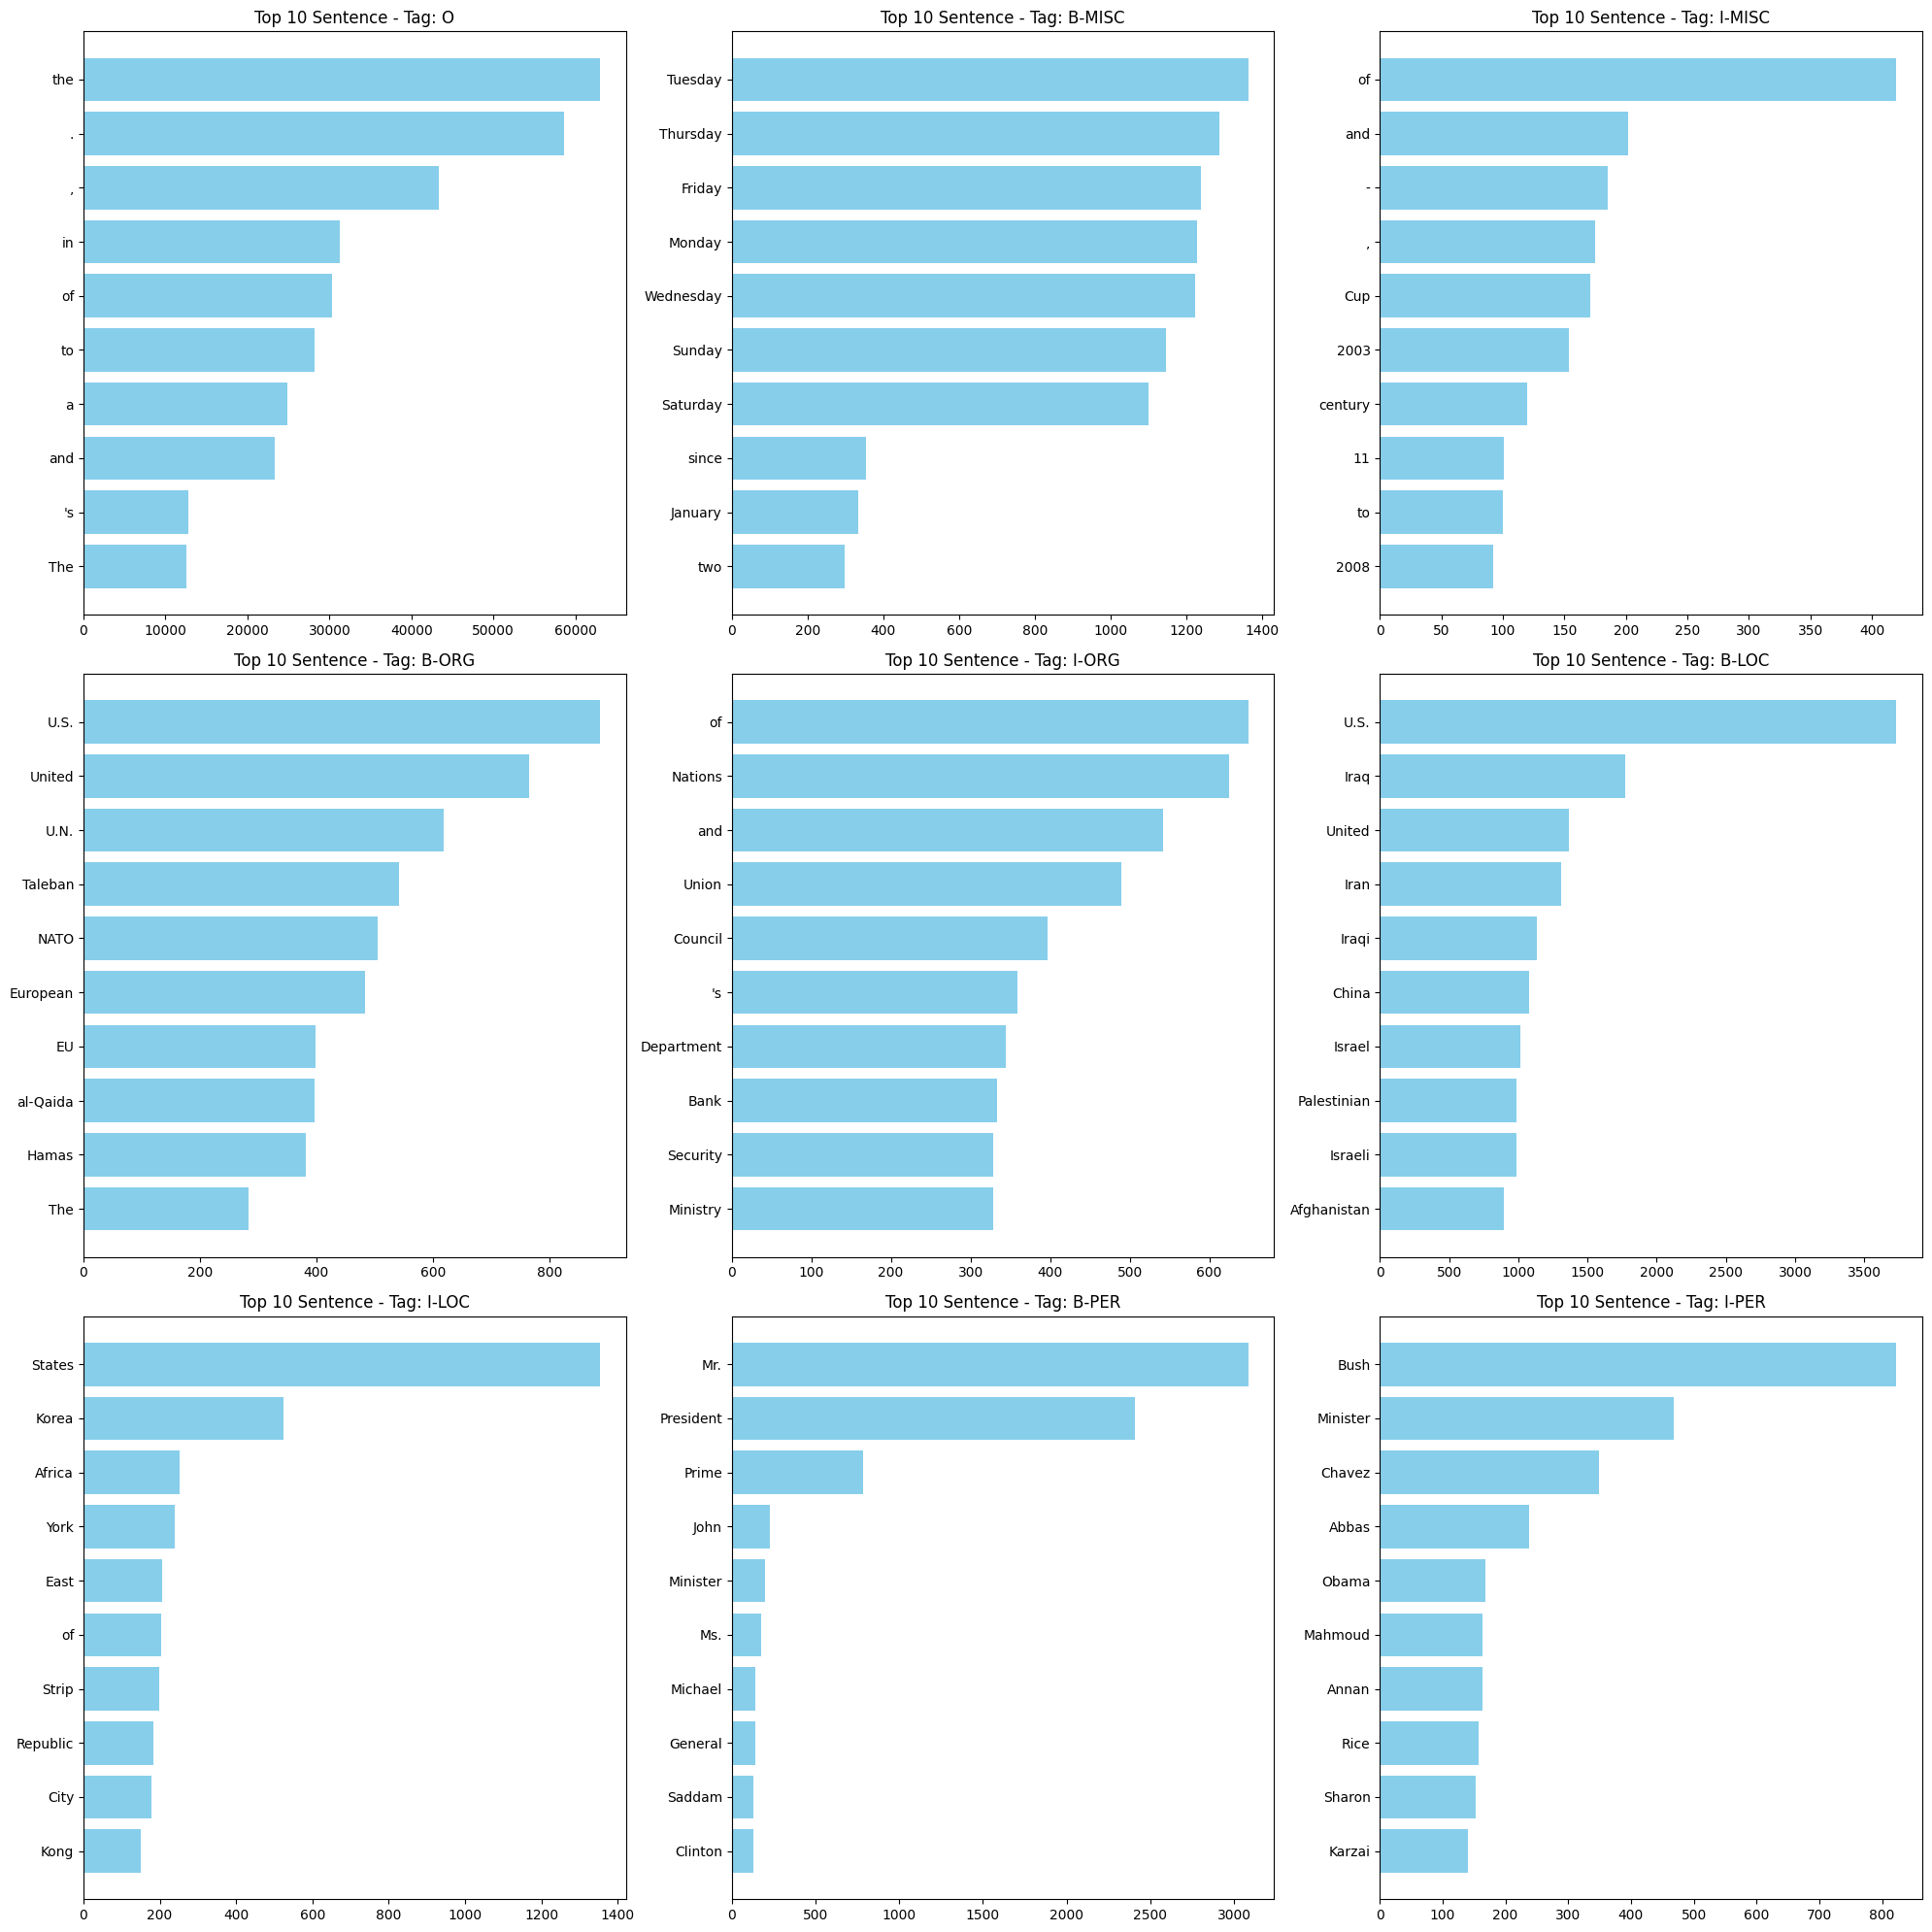

In [20]:
def topThings(data, col, compareCol, color):
  counter = defaultdict(defaultdict)
  for i in range(len(data)):
    a = list(builtins.zip(data.iloc[i][compareCol].split(),
                                        data.iloc[i][col]))
    for j in a:
      counter[j[1]][j[0]] = 1 if j[0] not in counter[j[1]] else \
                                          counter[j[1]][j[0]] + 1

  a = [sorted([(counter[i][j], i, j) for j in counter[i]],
                            reverse=True) for i in counter]

  plt.figure(figsize=(20, 20))
  c = 1
  for i in a:
    plt.subplot(3, 3, c)
    plt.barh(list(builtins.zip(*i))[2][:10][::-1],
             list(builtins.zip(*i))[0][:10][::-1], color=color)

    plt.tight_layout()
    plt.title("Top 10 "+compareCol+" - "+col+": "+tag_ids_to_tag[i[0][1]])
    c += 1

topThings(ner_corpus, 'Tag', 'Sentence', 'skyblue')

---

</br>

### Data Preprocessing and Preperation

</br>

Will define global parameters, import BERT tokenizer and create a preprocessor to preprocess dataset for a BERT based model

In [21]:
MAX_LEN = 125
BATCH_SIZE = 32

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                          do_lower_case=False)

This `DataPreprocessor` class performs the following:
1. Converts the sentences to a tokenized form, this is done by the BERT tokenizer which performs **word-piece** **tokenization**

2. Sentences and Tags will be preprocessed by padding them to same length, converting them to tensors, and combining them

3. Split the data into train/val/test datasets, and return them as `DataLoader` objects

In [159]:
class DataPreprocessor(object):

  def __init__(self, data, batch_size=32):
    self.data = data
    self.data_preprocessed = None
    self.tokenized = False
    self.preprocessed = False
    self.batch_size = batch_size
    self.train_data = None
    self.val_data = None
    self.test_data = None


  def tokenize_data(self, tokenizer):
    # Loop through each sentence
    for i in range(self.data.shape[0]):
      tokens, tags = [], []
      flag = True

      # Loop through each word in the sentence
      for (idx, word) in enumerate(self.data.iloc[i]['Sentence'].split()):
        #add tokenized words to tokens array
        tokenized_word = tokenizer.tokenize(word)
        tokens.extend(tokenized_word)
        try:
          # Add tags and make equal to number of pieces of word
          word_len = len(tokenized_word)
          tags.extend([self.data.iloc[i]['Tag'][idx]] * word_len)
        except:
          flag = False

      if flag:
        self.data.at[i, 'Sentence'] = tokens.copy()
        self.data.at[i, 'Tag'] = tags.copy()

    self.tokenized = True


  def preprocess_data(self, tokenizer, max_len, batch_size):
    sent_lens = self.data['Sentence'].apply(len)
    tag_lens = self.data['Tag'].apply(len)
    self.data = self.data[sent_lens == tag_lens]

    # Pad sentences and tags, and create attention mask
    attention_masks = self.data['Sentence'].apply(lambda x:
                              [1.0 for i in range(len(x))])
    attention_masks_padded = pad_sequences(attention_masks,
                                           maxlen=MAX_LEN, padding='post')

    converted_sentences = self.data['Sentence'].apply(lambda x:
                              tokenizer.convert_tokens_to_ids(x))
    sentence_padded = pad_sequences(converted_sentences,
                                    maxlen=MAX_LEN, padding='post')

    tags_padded = pad_sequences(self.data['Tag'],
                                    maxlen=MAX_LEN, padding='post')

    # Convert sentences, tags, and attention mask to tensor
    sentence_padded = torch.tensor(sentence_padded, dtype=float)
    attention_masks_padded = torch.tensor(attention_masks_padded,
                                                     dtype=float)
    tags_padded = torch.tensor(tags_padded, dtype=float)

    # Combine them into a TensorDataset
    self.data_preprocessed = TensorDataset(sentence_padded,
                                           attention_masks_padded,
                                                      tags_padded)

    self.preprocessed = True
    return self.data_preprocessed


  def train_val_test_split(self, train_size, val_size, test_size):
    gen1 = torch.Generator().manual_seed(42)
    self.train_data, self.val_data, self.test_data = random_split(
                          self.data_preprocessed,
                          [train_size, val_size, test_size], gen1)

    # Return DataLoader objects for each split
    self.train_data = DataLoader(self.train_data,
                                  batch_size=self.batch_size)
    self.val_data = DataLoader(self.val_data,
                                  batch_size=self.batch_size)
    self.test_data = DataLoader(self.test_data,
                                  batch_size=self.batch_size)



In [25]:
data_preprocessor = DataPreprocessor(ner_corpus)
data_preprocessor.tokenize_data(tokenizer)
data_preprocessor.preprocess_data(tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
data_preprocessor.train_val_test_split(0.7, 0.1, 0.2)

---

</br>

### Create and Define Models

</br>

Will create the following models:
1. Baseline BiLSTM Neural Network
2. Gated Convolutional Neural Network
3. BERT based transformer model from HuggingFace

In [27]:
class BiLSTM(torch.nn.Module):

  def __init__(self, tokenizer, input_dim, output_dim):
    super(BiLSTM, self).__init__()
    self.embedding = torch.nn.Embedding(len(tokenizer), 200)
    self.bilstm = torch.nn.LSTM(200, 16, bidirectional=True,
                                           batch_first=True)
    self.dropout = torch.nn.Dropout(0.2)
    self.output = torch.nn.Linear(32, output_dim)


  def forward(self, x):
    x1 = self.embedding(x)
    x2 = self.dropout(x1)

    x3 = self.bilstm(x2)[0]
    x4 = self.dropout(x3)
    output = self.output(x4)

    return output

In [28]:
class GatedCNN(torch.nn.Module):
  def __init__(self, tokenizer, input_dim, output_dim):
    super(GatedCNN, self).__init__()

    self.embedding = torch.nn.Embedding(len(tokenizer), 200)
    self.conv = torch.nn.Conv1d(200, 32, 3, padding='same')
    self.sigmoid = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(0.2)
    self.linear = torch.nn.Linear(32, 16)
    self.output = torch.nn.Linear(16, output_dim)


  def forward(self, x):
    x1 = self.embedding(x)
    x2 = self.dropout(x1)
    A = self.conv(x2.t())
    B = self.conv(x2.t())

    x3 = torch.multiply(A, self.sigmoid(B)).t()
    x4 = self.linear(x3)
    x5 = self.dropout(x4)
    output = self.output(x5)

    return output

In [ ]:
bert_model = BertForTokenClassification.from_pretrained(
            "bert-base-cased", num_labels=9,
            output_attentions=False, output_hidden_states=False)

---

</br>

### Train Models

Have to create seperate training functions for the neural network models and the BERT based model since their input format are different.

In [30]:
def model_acc(model, data):
  acc = []

  for (idx, b) in enumerate(data):
    batch = tuple(t.to(device) for t in b)

    # Dont update gradients
    with torch.no_grad():
      for i in range(batch[0].shape[0]):
        # Add another dimension to the tensor
        cur_data = batch[0][i].long().unsqueeze(0).long()[0]
        outputs = model.forward(cur_data)

        mask = batch[1][i].long().bool()
        target = batch[2][i].long()
        pred = torch.argmax(outputs, axis=1)

        pred = pred[mask]
        target = target[mask]

        # Add current accuracy to acc array
        acc.append((pred == target).float().mean().item())

  return np.mean(np.array(acc))


def train_model(model, epochs, data, val_data, eval_step=200):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  total_steps = len(data) * epochs

  # Decreases learning rate after every time step
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  history = {"Epoch": [], "Batch": [], "Loss": [], "Val_acc": []}

  for epoch in range(epochs):
    total_loss = 0

    for (idx, b) in enumerate(data):
      batch = tuple(t.to(device) for t in b)
      batch_loss = 0

      # Batch gradient descent
      for i in range(batch[0].shape[0]):
        cur_data = batch[0][i].long().unsqueeze(0).long()[0]

        output = model.forward(cur_data)
        pred = torch.argmax(output, axis=1)
        target = batch[2][i].long()

        # Calculate loss after every batch pass
        batch_loss += loss_fn(output, target)

      batch_loss.backward()
      optimizer.step()
      scheduler.step()

      if idx % eval_step == 0:
        val_accuracy = round(model_acc(model, val_data) * 100, 3)
        print("Epoch ", epoch, "   Batch: ", idx, "   Loss: ",
              batch_loss.item(),"   Valid accuracy: ",
              val_accuracy, "%")

        history['Epoch'].append(epoch)
        history['Batch'].append(idx)
        history['Loss'].append(batch_loss.item())
        history['Val_acc'].append(val_accuracy)
    print("\n")
  print("Model training finished. \n\n")
  return history

In [31]:
def plot_hist(hist, model_name):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)

  epoch_arr = np.linspace(0, max(hist['Epoch']) + 1, len(hist['Epoch']))
  plt.plot(epoch_arr, hist['Loss'])
  plt.title("Training Loss - " + model_name)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(epoch_arr, hist['Val_acc'], color='orange')
  plt.title("Validation Accuracy - " + model_name)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")


  plt.tight_layout()

In [ ]:
bilstm = BiLSTM(tokenizer, 200, 9).cuda()
gatedcnn = GatedCNN(tokenizer, 200, 9).cuda()
epochs = 3

bilstm_hist = train_model(bilstm, epochs, data_preprocessor.train_data,
                                            data_preprocessor.val_data)

gcnn_hist = train_model(gatedcnn, epochs, data_preprocessor.train_data,
                                            data_preprocessor.val_data)


Epoch  0    Batch:  0    Loss:  74.47716522216797    Valid accuracy:  6.55 %
Epoch  0    Batch:  200    Loss:  4.007850646972656    Valid accuracy:  78.854 %
Epoch  0    Batch:  400    Loss:  2.673699378967285    Valid accuracy:  79.684 %
Epoch  0    Batch:  600    Loss:  4.032776355743408    Valid accuracy:  80.499 %
Epoch  0    Batch:  800    Loss:  3.7598140239715576    Valid accuracy:  81.267 %
Epoch  0    Batch:  1000    Loss:  3.6509807109832764    Valid accuracy:  81.667 %
Epoch  0    Batch:  1200    Loss:  1.970512866973877    Valid accuracy:  81.68 %
Epoch  0    Batch:  1400    Loss:  3.952915668487549    Valid accuracy:  81.715 %


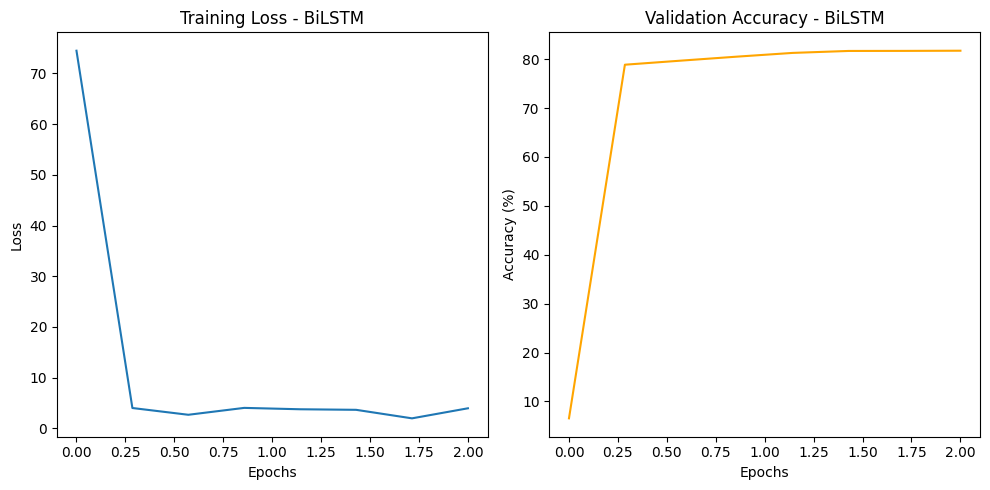

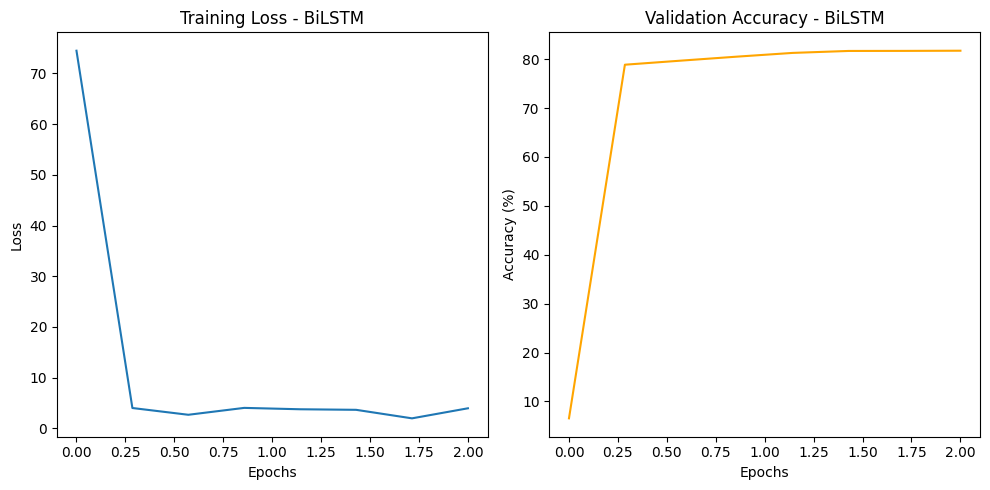

In [ ]:
plot_hist(bilstm_hist, "BiLSTM")
plot_hist(gcnn_hist, "GatedCNN")

In [160]:
def bert_acc(model, val_data):
  model.eval()
  acc = []
  for (idx, b) in enumerate(val_data):
    batch = tuple(t.to(device) for t in b)
    # Dont update gradients
    with torch.no_grad():
      outputs = model(batch[0].long(), token_type_ids=None,
                            attention_mask=batch[1].long(),
                                    labels=batch[2].long())

      # Calculate accuracy on every batch in val data
      for i in range(batch[1].shape[0]):
        mask = batch[1][i].long() != 0
        pred = torch.argmax(outputs[1][i], axis=1)[mask]
        target = batch[2][i].long()[mask]

        acc.append((pred == target).float().mean().item())

  return np.mean(np.array(acc))


def train_bert_model(model, epochs, data, val_data, eval_step):
  named_params = list(model.classifier.named_parameters())
  model_params = [{
      "params": [p for n, p in named_params]
  }]

  optimizer = torch.optim.AdamW(model_params, lr=0.001)
  total_steps = len(data) * epochs

  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  history = {"Epoch": [], "Batch": [], "Loss": [], "Val_acc": []}

  for epoch in range(epochs):
    model.train()
    total_loss = 0

    for (idx, b) in enumerate(data):
      batch = tuple(t.to(device) for t in b)

      # Refresh gradients
      model.zero_grad()
      outputs = model(batch[0].long(), token_type_ids=None,
                            attention_mask=batch[1].long(),
                                    labels=batch[2].long())

      # Compute loss
      loss = outputs[0]
      total_loss += loss.item()
      loss.backward()

      # Clip gradient to avoid exploding gradient
      torch.nn.utils.clip_grad_norm(parameters=model.parameters(),
                                                    max_norm=1.0)
      optimizer.step()
      scheduler.step()

      # Print metrics after every eval step
      if idx % eval_step == 0:
        val_accuracy = round(bert_acc(model, val_data) * 100, 3)
        print("Epoch ", epoch, "   Batch: ", idx, "   Loss: ",
              loss.item(),"   Valid accuracy: ",
              val_accuracy, "%")

        history['Epoch'].append(epoch)
        history['Batch'].append(idx)
        history['Loss'].append(loss.item())
        history['Val_acc'].append(val_accuracy)
    print("\n")
  print("Model training finished. \n\n")
  return history

In [ ]:
bert_model = bert_model.to(device)
bert_hist = train_bert_model(bert_model, 2, data_preprocessor.train_data,
                                         data_preprocessor.val_data, 200)

<ipython-input-121-2fbfbdd75526>:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(parameters=model.parameters(),


Epoch  0    Batch:  0    Loss:  0.09457673132419586    Valid accuracy:  86.582 %
Epoch  0    Batch:  200    Loss:  0.06883834302425385    Valid accuracy:  87.827 %
Epoch  0    Batch:  400    Loss:  0.0471358522772789    Valid accuracy:  88.293 %


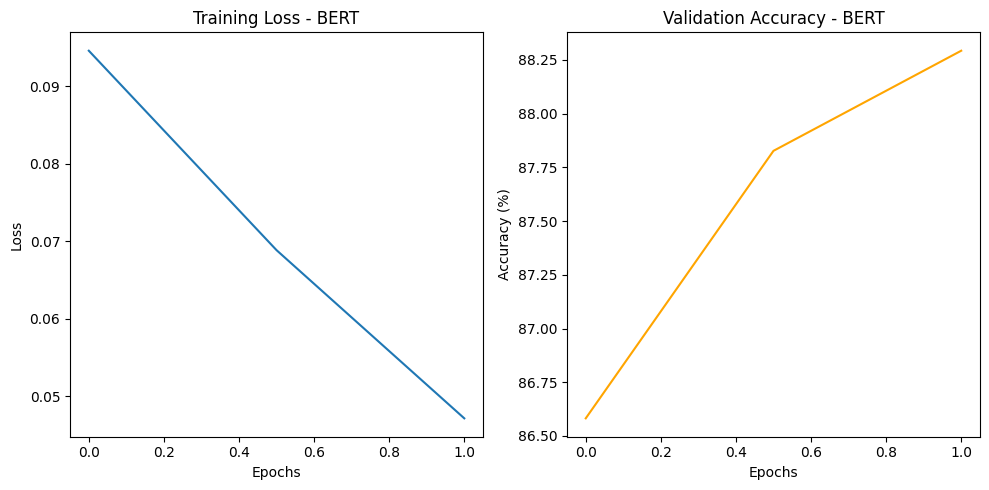

In [ ]:
plot_hist(bert_hist, "BERT")

In [ ]:
torch.save(bilstm, 'bilstm.pth')
torch.save(gatedcnn, 'gatedcnn.pth')
bert_model.save_pretrained('bert_model')

---

</br>

### Evaluate Models

</br>

Plot performance of each model on test data

In [166]:
bilstm = torch.load('bilstm.pth')
gated_cnn = torch.load('gatedcnn.pth')
bert_model = BertForTokenClassification.from_pretrained("bert_model")
bert_model = bert_model.cuda()

In [ ]:
def test_accuracy(model, test_data):
  model_pred = []
  target_arr = []
  for (idx, b) in enumerate(test_data):
    if idx % 200 == 0:
      print("Evaluating Batch: ", idx)
    batch = tuple(t.to(device) for t in b)
    with torch.no_grad():
      for i in range(batch[1].shape[0]):
        cur_data = batch[0][i].long().unsqueeze(0).long()[0]

        output = model.forward(cur_data)
        pred = torch.argmax(output, axis=1)
        target = batch[2][i].long()

        model_pred.extend(pred.cpu().numpy())
        target_arr.extend(target.cpu().numpy())

  target_names = list(tag_ids_to_tag.values())
  return classification_report(y_true=target_arr, y_pred=model_pred,
                               labels=np.arange(len(target_names)),
                               target_names=target_names,
                               output_dict=True)


In [ ]:
def bert_test_accuracy(model, test_data):
  model.eval()
  model_pred = []
  target_arr = []
  for (idx, b) in enumerate(test_data):
    if idx % 200 == 0:
      print("Evaluating Batch: ", idx)
    batch = tuple(t.to(device) for t in b)
    with torch.no_grad():
      outputs = model(batch[0].long(), token_type_ids=None,
                            attention_mask=batch[1].long(),
                                    labels=batch[2].long())

      for i in range(batch[1].shape[0]):
        mask = batch[1][i].long() != 0
        pred = torch.argmax(outputs[1][i], axis=1)[mask]
        target = batch[2][i].long()[mask]
        model_pred.extend(pred.cpu().numpy())
        target_arr.extend(target.cpu().numpy())

  target_names = list(tag_ids_to_tag.values())
  return classification_report(y_true=target_arr, y_pred=model_pred,
                               labels=np.arange(len(target_names)),
                               target_names=target_names,
                               output_dict=True)

In [ ]:
bilstm_report = test_accuracy(bilstm, data_preprocessor.test_data)
gatedcnn_report = test_accuracy(gated_cnn, data_preprocessor.test_data)
bert_report = bert_test_accuracy(bert_model, data_preprocessor.test_data)

Evaluating Batch:  0
Evaluating Batch:  200
Evaluating Batch:  400
Evaluating Batch:  0
Evaluating Batch:  200
Evaluating Batch:  400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating Batch:  0
Evaluating Batch:  200
Evaluating Batch:  400


<Axes: title={'center': 'Bert Model Classification Report'}>

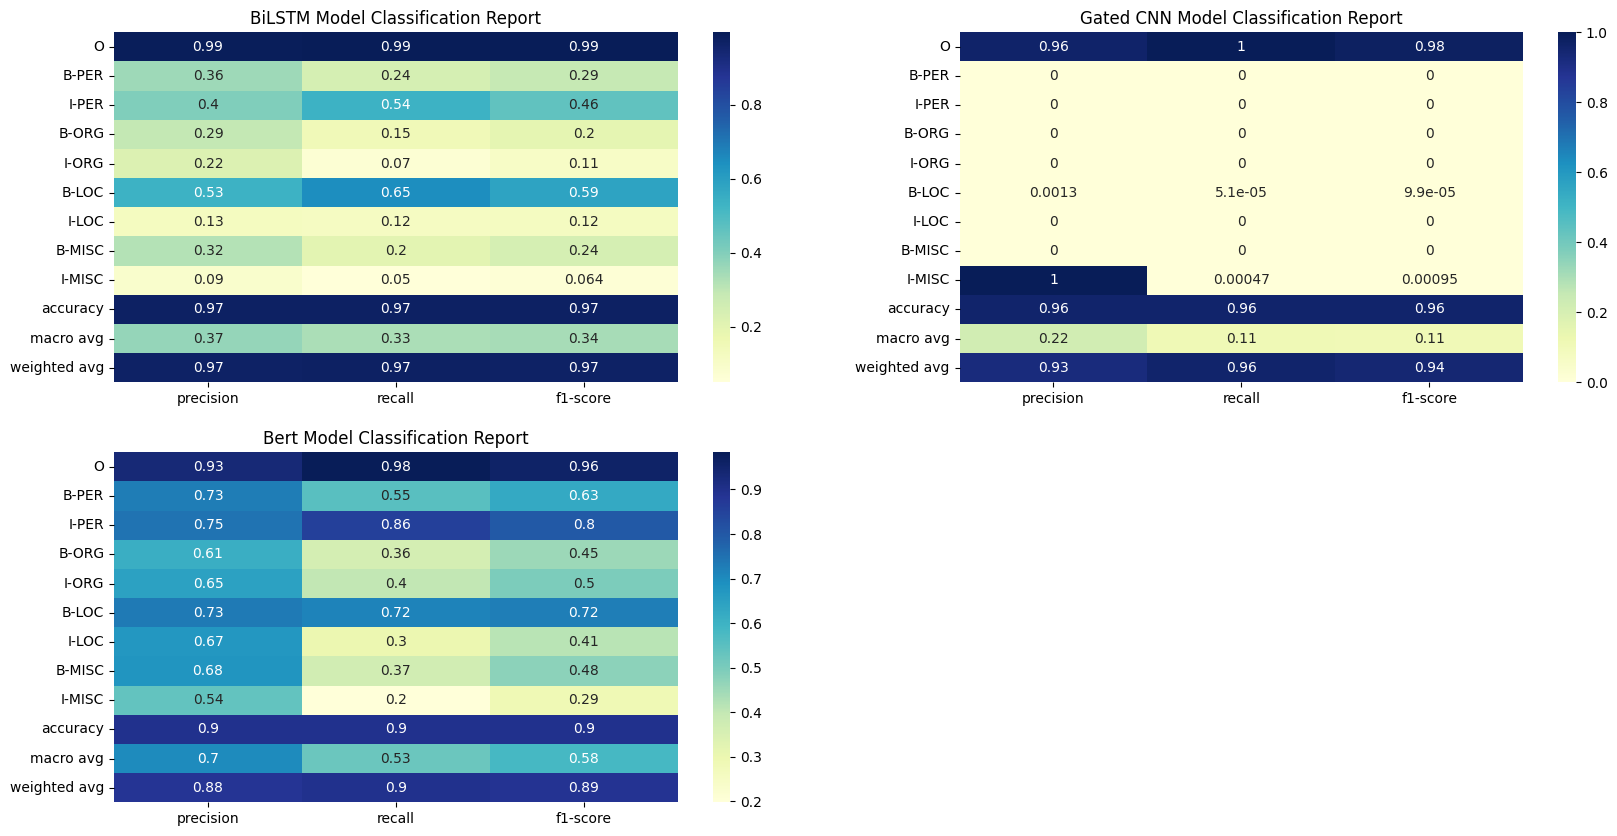

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.title("BiLSTM Model Classification Report")
sns.heatmap(pd.DataFrame(bilstm_report).iloc[:-1, :].T,
                            annot=True, cmap='YlGnBu')
plt.subplot(2, 2, 2)
plt.title("Gated CNN Model Classification Report")
sns.heatmap(pd.DataFrame(gatedcnn_report).iloc[:-1, :].T,
                            annot=True, cmap='YlGnBu')
plt.subplot(2, 2, 3)
plt.title("Bert Model Classification Report")
sns.heatmap(pd.DataFrame(bert_report).iloc[:-1, :].T,
                            annot=True, cmap='YlGnBu')

---

</br>

### BERT Inferencing

</br>

Inferencing pipeline to extract the company name out of a particular string of text.
- Preprocess string
- Get prediction from model
- Extract company name based on predicted tags

In [167]:
def preprocess_input(s):
  tokens = tokenizer.tokenize(s)
  tokens_converted = tokenizer.convert_tokens_to_ids(tokens)

  attention_mask = pad_sequences([[1.0 for i in range(len(tokens))]],
                                    maxlen=MAX_LEN, padding='post')

  tokens_padded = pad_sequences([tokens_converted], maxlen=MAX_LEN,
                                                  padding='post')

  attention_mask = torch.tensor(attention_mask, dtype=float)
  tokens_padded = torch.tensor(tokens_padded, dtype=float)

  return TensorDataset(tokens_padded, attention_mask), tokens


def predict(model, input_str):
  s, initial_tokens = preprocess_input(input_str)
  model.eval()
  input_ids = s[0][0].unsqueeze(0).long().to(device)
  attention_mask = s[0][1].unsqueeze(0).long().to(device)
  pred = []
  with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=attention_mask)

    attention_mask = attention_mask.bool()
    pred = torch.argmax(output[0][0], axis=1)[attention_mask[0]]
  return (initial_tokens, pred.cpu().numpy(),
              output[0][0][attention_mask[0]])


def extract_name(arr, probs):
  nlp = spacy.load("en_core_web_sm")
  visited = set()
  company_dict = defaultdict(int)
  for i in range(len(arr)):
    if i in visited:
      continue
    if arr[i][1] == 3:
      l, r = i, i
      while (l > 0 and arr[l][0][0] == '#') or (l > 0 and arr[l - 1][0][-1] == '#'):
        l -= 1
      while (r < len(arr) and arr[r][0][-1] == '#') or (r < len(arr) - 1 and arr[r + 1][0][0] == '#'):
        r += 1

      thing = ""
      full_str = arr[l:r+1]
      for j in full_str:
        for k in j[0]:
          if k != '#':
            thing += k

      company_dict[thing] += 1
      for x in range(l, r+1):
        visited.add(x)

  stop_words = set(stopwords.words("english"))

  bad = []
  for i in company_dict:
    if i.lower() in stop_words or i.lower() in string.punctuation:
      print(i.lower())
      bad.append(i)
  for i in bad:
    company_dict.pop(i)

  arr = sorted([[i, company_dict[i]] for i in company_dict], reverse=True)
  if not arr:
    return ""
  return arr[0][0]

In [206]:
s = 'Thank you for applying to the software engineering position at Uber.'

t, p, probs = predict(bert_model, s)

arr = list(builtins.zip(t, p))
extract_name(arr, probs)

'Uber'